In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm


import os
from glob import glob
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torchvision import transforms
import cv2
import albumentations as album

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import numpy as np
from PIL import Image


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:

class AttentionBlock(nn.Module):
    '''
    AttentionBlock Class
    Values:
    channels: number of channels in input
    '''
    def __init__(self, channels):
        super().__init__()

        self.channels = channels

        self.theta = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=False))
        self.phi = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=False))
        self.g = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 2, kernel_size=1, padding=0, bias=False))
        self.o = nn.utils.spectral_norm(nn.Conv2d(channels // 2, channels, kernel_size=1, padding=0, bias=False))

        self.gamma = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        spatial_size = x.shape[2] * x.shape[3]

        # Apply convolutions to get query (theta), key (phi), and value (g) transforms
        theta = self.theta(x)
        phi = F.max_pool2d(self.phi(x), kernel_size=2)
        g = F.max_pool2d(self.g(x), kernel_size=2)

        # Reshape spatial size for self-attention
        theta = theta.view(-1, self.channels // 8, spatial_size)
        phi = phi.view(-1, self.channels // 8, spatial_size // 4)
        g = g.view(-1, self.channels // 2, spatial_size // 4)

        # Compute dot product attention with query (theta) and key (phi) matrices
        beta = F.softmax(torch.bmm(theta.transpose(1, 2), phi), dim=-1)

        # Compute scaled dot product attention with value (g) and attention (beta) matrices
        o = self.o(torch.bmm(g, beta.transpose(1, 2)).view(-1, self.channels // 2, x.shape[2], x.shape[3]))

        # Apply gain and residual
        return self.gamma * o + x




In [3]:

### The model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.residual(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.down_convolution_1 = ResidualBlock(in_channels, 64)
        self.down_convolution_2 = ResidualBlock(64, 128)
        self.down_convolution_3 = ResidualBlock(128, 256)
        self.down_convolution_4 = ResidualBlock(256, 512)
        self.down_convolution_5 = ResidualBlock(512, 1024)

        self.att3 = AttentionBlock(512)
        self.att4 = AttentionBlock(1024)

        self.up_transpose_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_convolution_1 = ResidualBlock(1024, 512)

        self.up_transpose_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_convolution_2 = ResidualBlock(512, 256)

        self.up_transpose_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_convolution_3 = ResidualBlock(256, 128)

        self.up_transpose_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_convolution_4 = ResidualBlock(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        
        down_7 = self.down_convolution_4(down_6)
        att3 = self.att3(down_7)
        down_8 = self.max_pool2d(att3)
        
        down_9 = self.down_convolution_5(down_8)
        att4 = self.att4(down_9)

        up_1 = self.up_transpose_1(att4)
        up_2 = self.up_convolution_1(torch.cat([att3, up_1], dim=1))
        
        up_3 = self.up_transpose_2(up_2)
        up_4 = self.up_convolution_2(torch.cat([down_5, up_3], dim=1))
        
        up_5 = self.up_transpose_3(up_4)
        up_6 = self.up_convolution_3(torch.cat([down_3, up_5], dim=1))
        
        up_7 = self.up_transpose_4(up_6)
        up_8 = self.up_convolution_4(torch.cat([down_1, up_7], dim=1))

        out = self.out(up_8)

        return torch.sigmoid(out)  # ✅ Activation finale pour la segmentation


In [5]:
import os
import cv2
import numpy as np
import albumentations as album
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F


def windowed(tensor: torch.Tensor, w: int, l: int):
    px = tensor.clone()
    px_min = l - w // 2
    px_max = l + w // 2
    px[px < px_min] = px_min
    px[px > px_max] = px_max
    return (px - px_min) / (px_max - px_min)


def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
        album.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=cv2.BORDER_REFLECT),
        album.OneOf([
            album.CLAHE(p=1),
            album.RandomGamma(p=1),
            album.RandomBrightnessContrast(p=1),
        ], p=0.9),
        album.OneOf([
            album.Blur(blur_limit=3, p=1),
            album.MotionBlur(blur_limit=3, p=1),
            album.GaussianBlur(blur_limit=3, p=1),
        ], p=0.9),
        album.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        album.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [album.PadIfNeeded(384, 480)]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
    return album.Compose(_transform)

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_msk=None, augmentations=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_img = transform_img
        self.transform_msk = transform_msk
        self.augmentations = augmentations
        
        self.image_paths = sorted(glob(os.path.join(self.image_dir, '*.png')))
        self.mask_paths = sorted(glob(os.path.join(self.mask_dir, '*_mask.png')))

        self.image_paths = [img for img in self.image_paths if '_mask' not in img]

        if len(self.image_paths) != len(self.mask_paths):
            print(f"Found {len(self.image_paths)} images and {len(self.mask_paths)} masks")
            raise ValueError("Mismatch between number of images and masks")
        
        self.transform_img = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        self.transform_msk = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask, dtype=np.float32) / 255.0  # ✅ Normalisation des masques

        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        image = self.transform_img(Image.fromarray(image))
        mask = self.transform_msk(Image.fromarray(mask)).float()  # ✅ Conversion en float

        image = windowed(image, 400, 40)
        
        return image, mask


In [6]:
# Define the paths to the training and testing data (directories, not files)
train_image_dir = "/kaggle/input/digital-medical-images-for--download-resource/div-images/train/"
train_mask_dir = "/kaggle/input/digital-medical-images-for--download-resource/div-images/train/"
test_image_dir = "/kaggle/input/digital-medical-images-for--download-resource/div-images/test/"
test_mask_dir = "/kaggle/input/digital-medical-images-for--download-resource/div-images/test/"

In [7]:

# Create the dataset with augmentations
train_augmentations = get_training_augmentation()
val_augmentations = get_validation_augmentation()

full_dataset = CustomDataset(train_image_dir, train_mask_dir, augmentations=train_augmentations)

# Define the percentage for splitting (e.g., 80% training, 20% validation)
train_percentage = 0.8
val_percentage = 1 - train_percentage

# Calculate lengths for each split
train_size = int(train_percentage * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders for both training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the device to be used for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_dataset = CustomDataset(test_image_dir, test_mask_dir)

#Create DataLoaders for both training and validation datasets
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:230: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
<ipython-input-5-4bcce5d9f4c1>:40: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  album.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),


In [8]:
model = UNet().to(device)
####" Train
# Setup loss function and optimizer
criterion = nn.BCEWithLogitsLoss()# DiceLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001 )

import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice



import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# Define your loss functions, optimizer, and other components
loss_fn_1 = DiceLoss()
loss_fn_2 = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
torch.manual_seed(42)
epochs = 6000
train_total_losses = []
val_total_losses = []

# Initialize the best validation loss to a high value
best_val_loss = float('inf')

def load_image(filename):
    pixels = np.array(Image.open(filename))
    pixels = ((pixels - 127.5) / 127.5) + 0.5
    return pixels



In [9]:

def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i, image in enumerate(display_list):
        if image is None:
            continue
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        cmap = None
        if i > 0:
            cmap = plt.cm.gray
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
    plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

best_val_loss = float("inf")
train_total_losses, val_total_losses = [], []

for epoch in tqdm(range(epochs)):
    train_losses, val_losses = [], []
    print(f"Epoch {epoch+1}/{epochs}")

    train_loss_1, train_loss_2, train_loss = 0, 0, 0
    val_loss_1, val_loss_2, val_loss = 0, 0, 0  # ✅ Correct initialization

    # 🔥 TRAINING PHASE
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        y_pred = torch.sigmoid(y_pred)  # Convert logits to probabilities

        loss_1 = loss_fn_1(y_pred, y)
        loss_2 = loss_fn_2(y_pred, y)
        loss = loss_1 + loss_2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    # 🔥 VALIDATION PHASE
    model.eval()
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred = torch.sigmoid(y_pred)

            loss_1 = loss_fn_1(y_pred, y)
            loss_2 = loss_fn_2(y_pred, y)
            loss = loss_1 + loss_2

            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    train_total_losses.append(train_loss)
    val_total_losses.append(val_loss)

    # 🔥 VISUALIZATION (1 triplet per epoch)
    batch = next(iter(val_loader))
    images, gt_masks = batch
    images, gt_masks = images.to(device), gt_masks.to(device)


    with torch.no_grad():
            model.eval()
            logits = model(images)
            pr_masks = torch.sigmoid(logits).squeeze(1)

    # Select the first image from the batch for visualization
    img, gt_mask, pr_mask = images[0], gt_masks[0], pr_masks[0]
    
    if (epoch + 1) % 20 == 0:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.cpu().squeeze().numpy(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().squeeze().numpy(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

    # 🔥 MODEL SAVING
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✅ Saved best model with validation loss: {val_loss:.4f}")

    if (epoch + 1) % 20 == 0:
        torch.save(model.state_dict(), f"model_epoch{epoch+1}.pth")


In [16]:
torch.save(model.state_dict(), f"./model.pth")

In [11]:
postmodel = UNet().to(device)
postmodel.load_state_dict(torch.load("/kaggle/input/pretrained-unet-models-liver/best_model.pth"))
postmodel.eval()

<ipython-input-11-caba7462c731>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  postmodel.load_state_dict(torch.load("/kaggle/input/pretrained-unet-models-liver/best_model.

UNet(
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_convolution_1): ResidualBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (residual): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (down_convolution_2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (resid

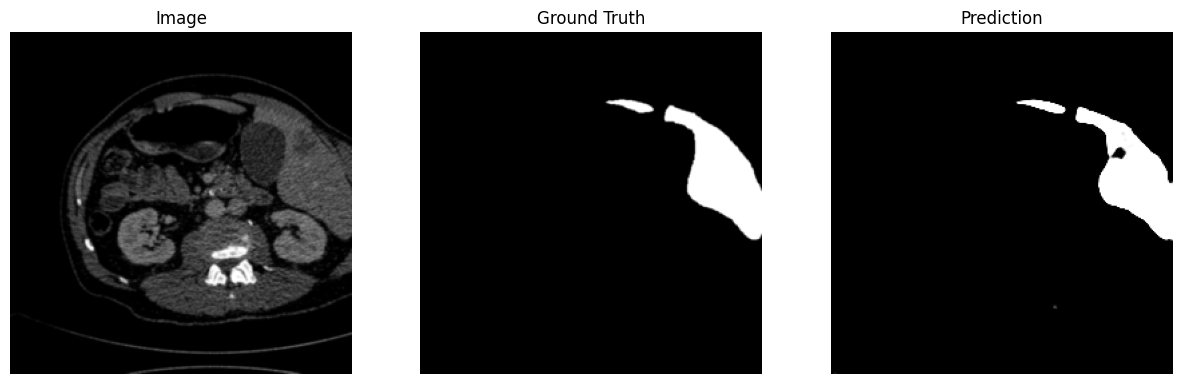

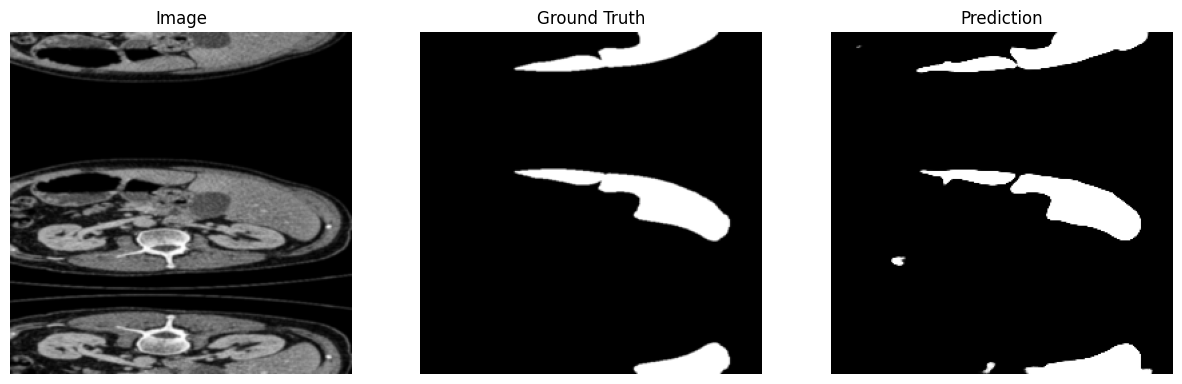

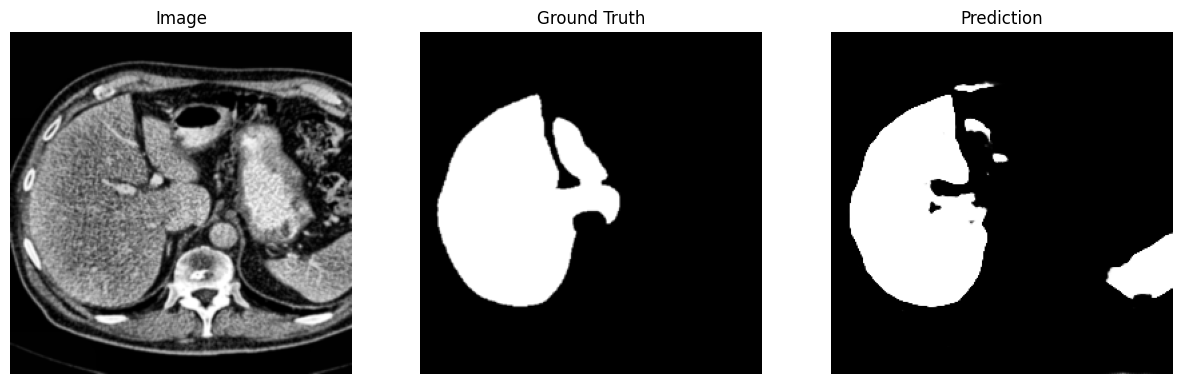

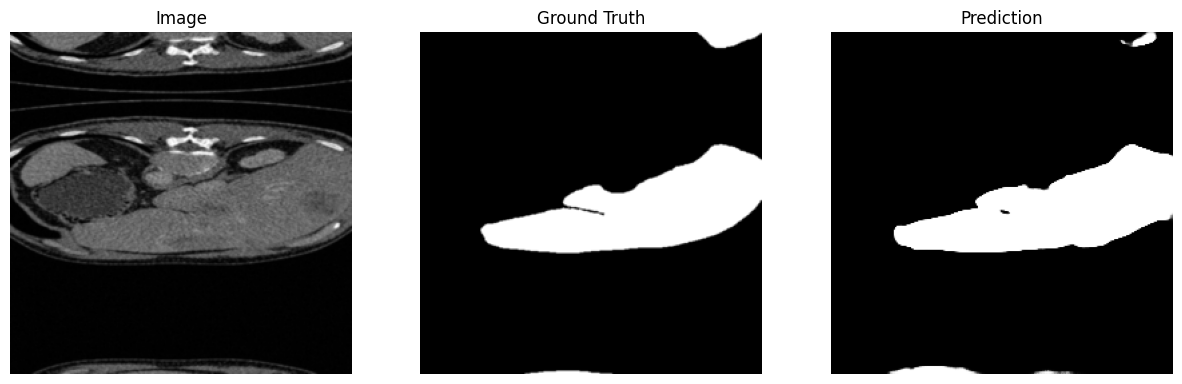

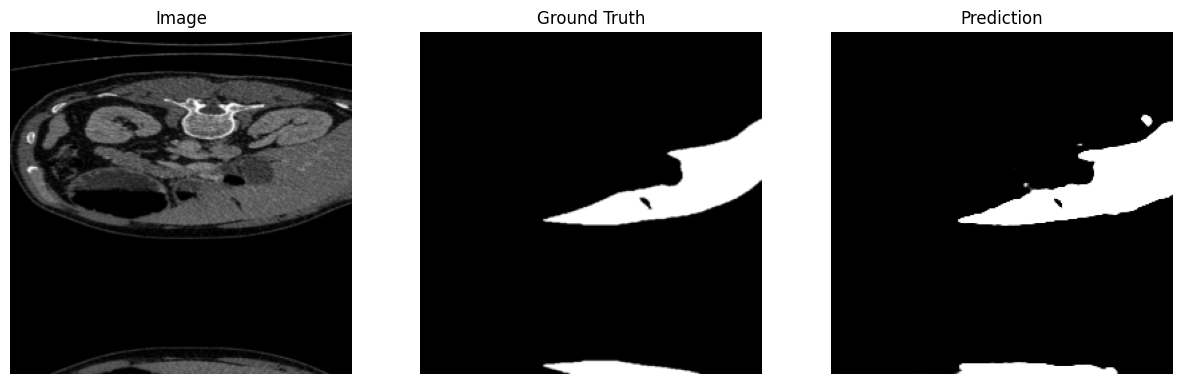

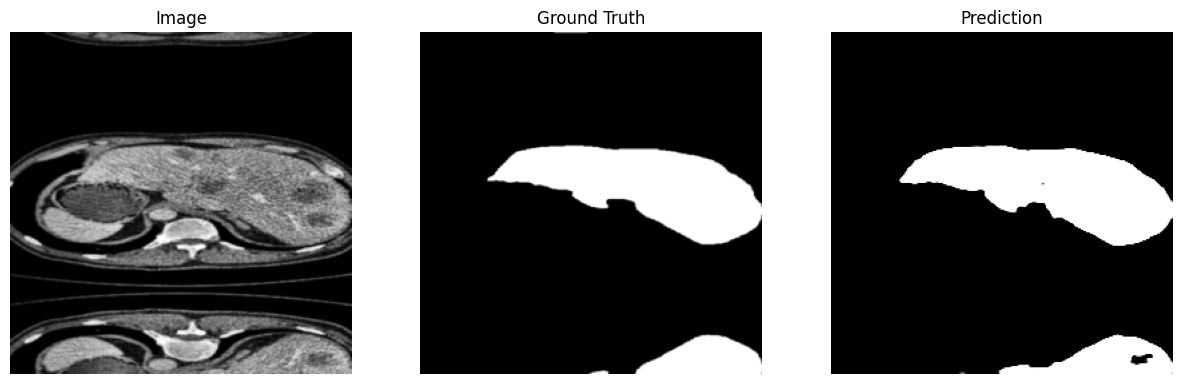

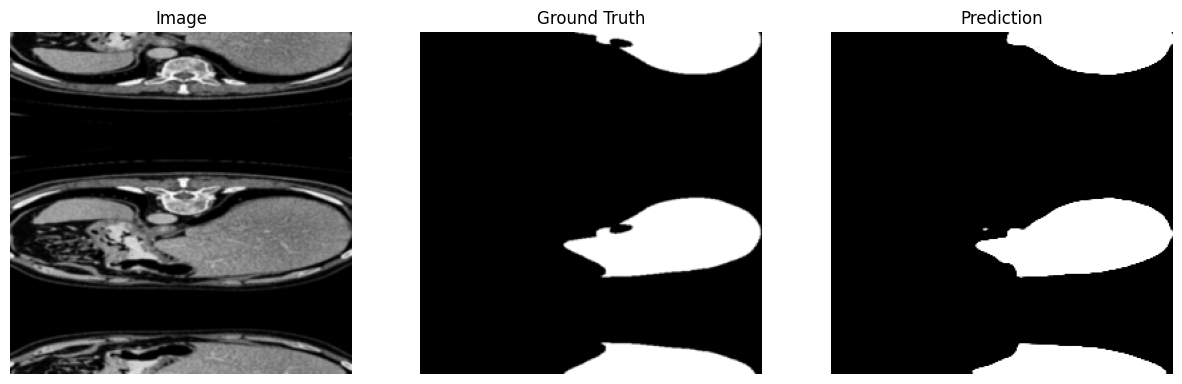

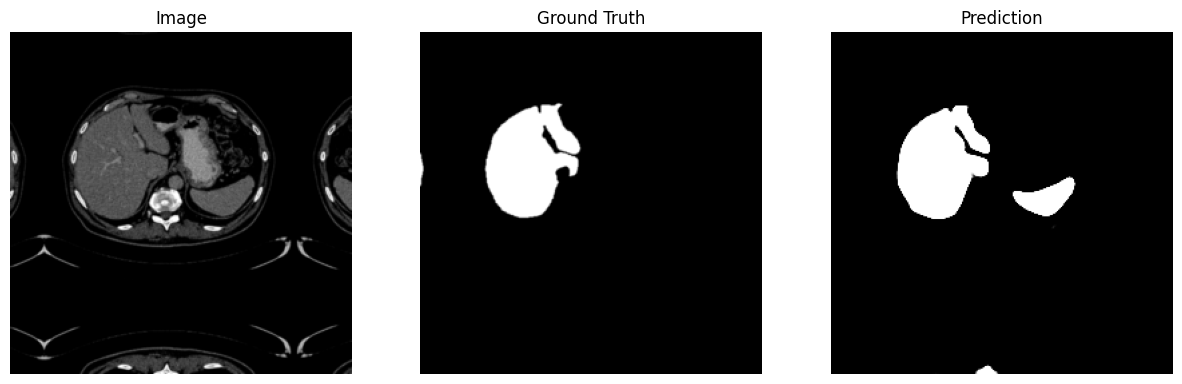

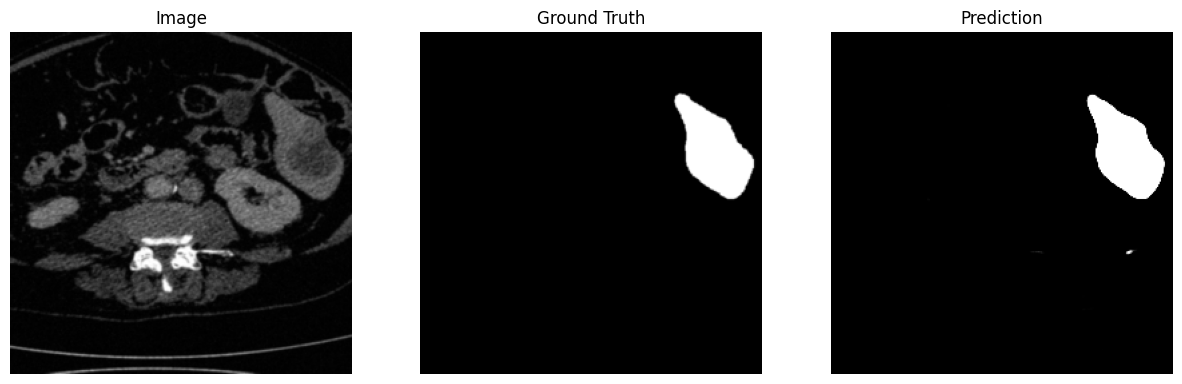

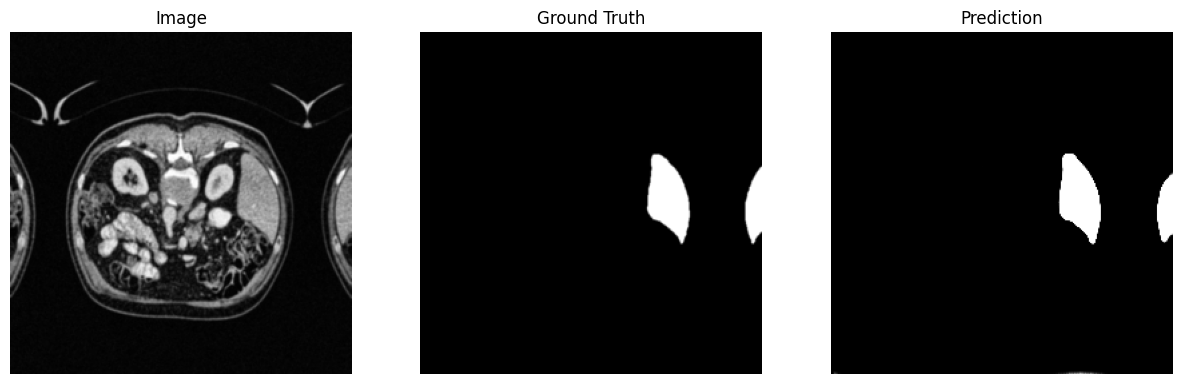

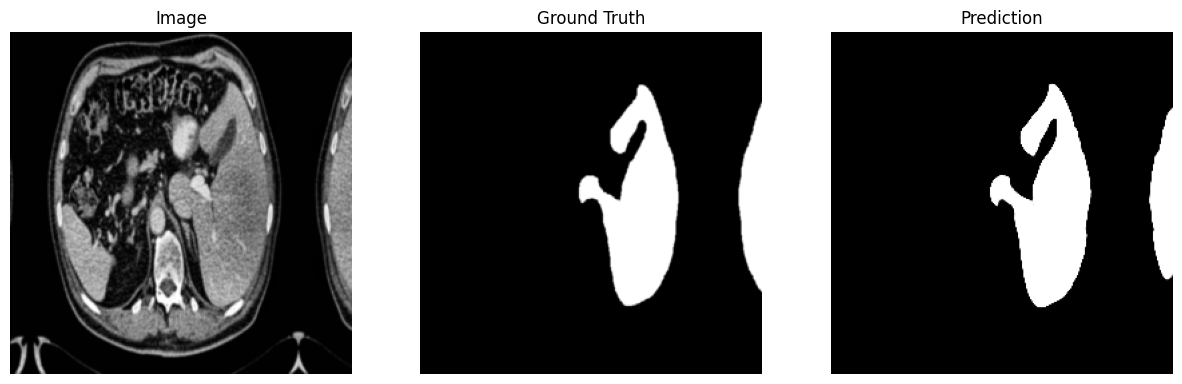

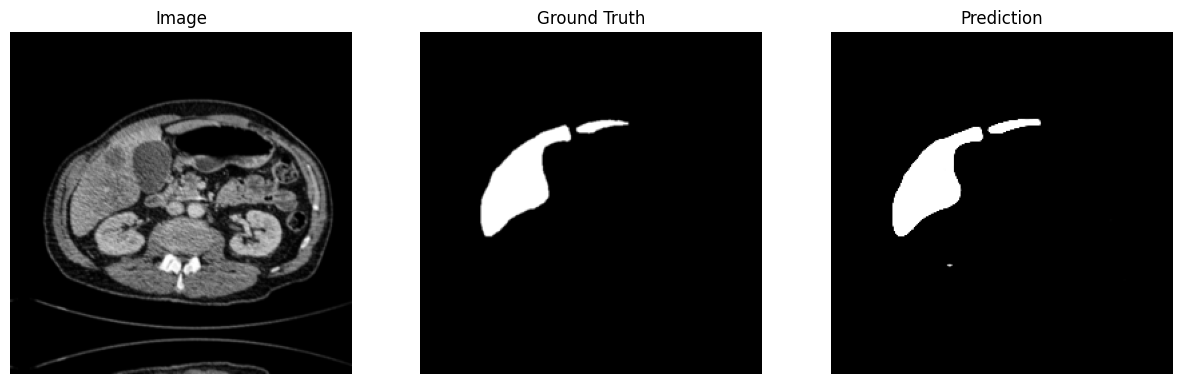

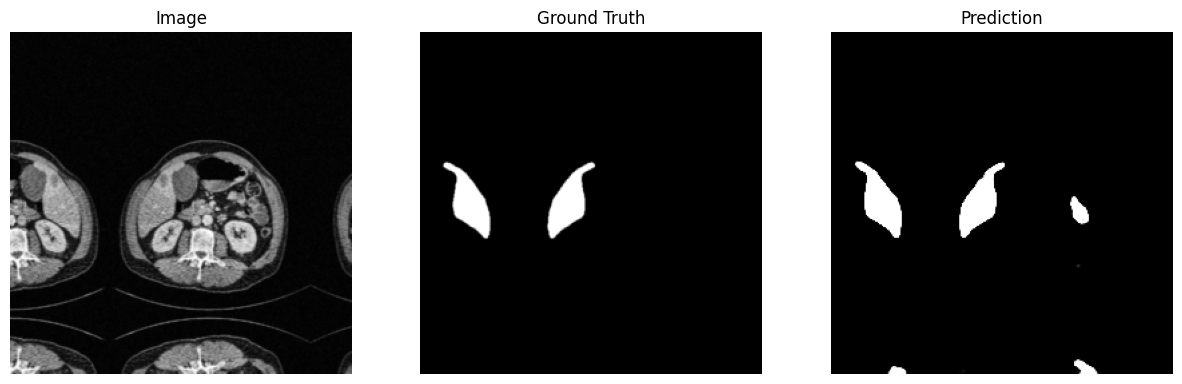

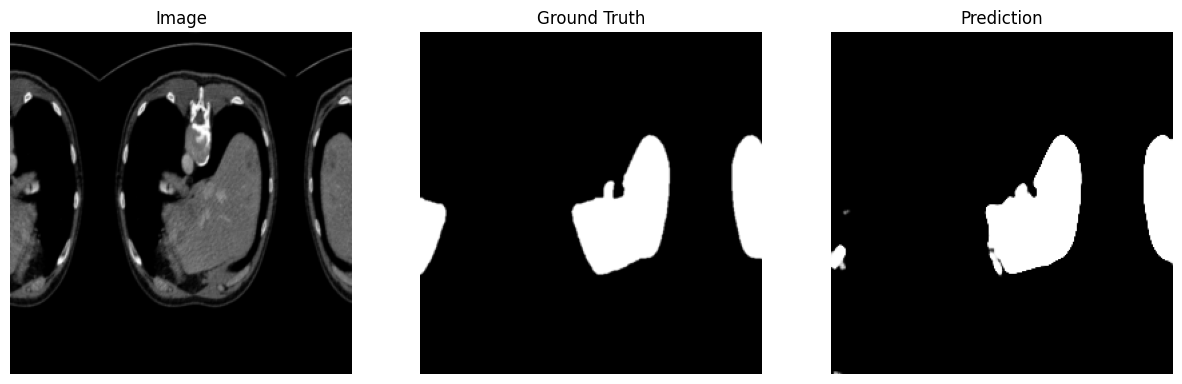

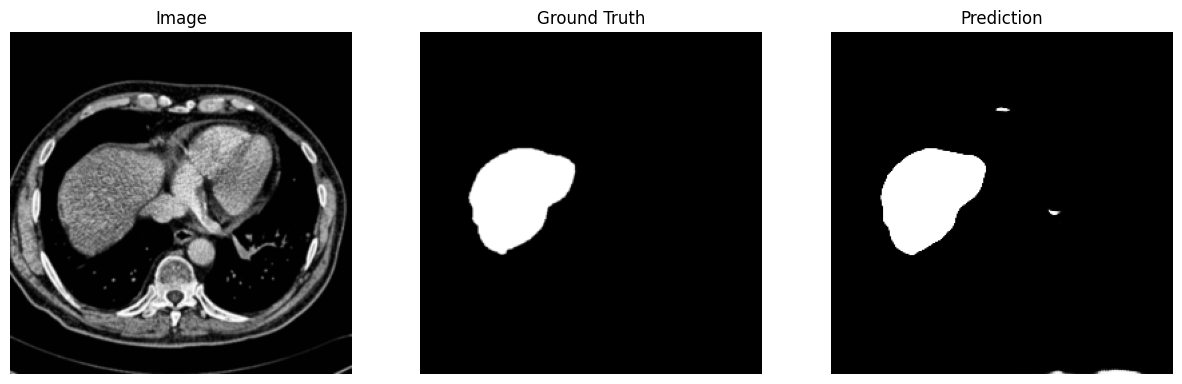

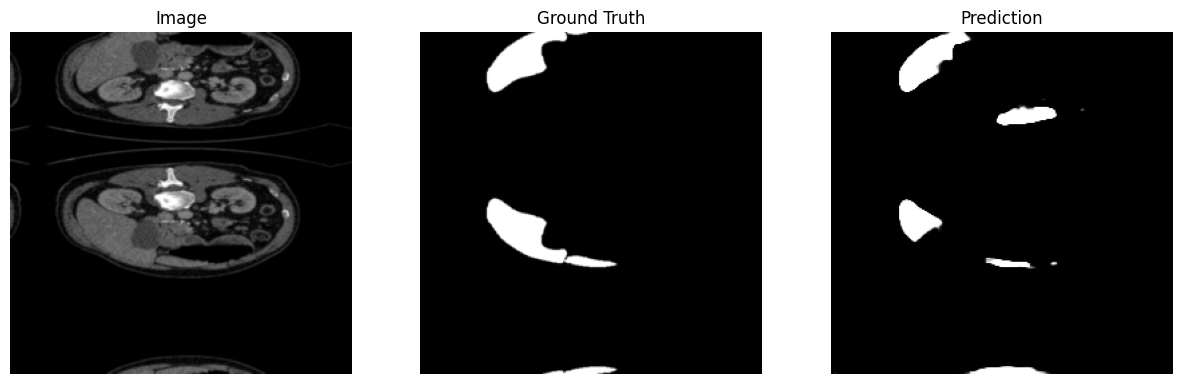

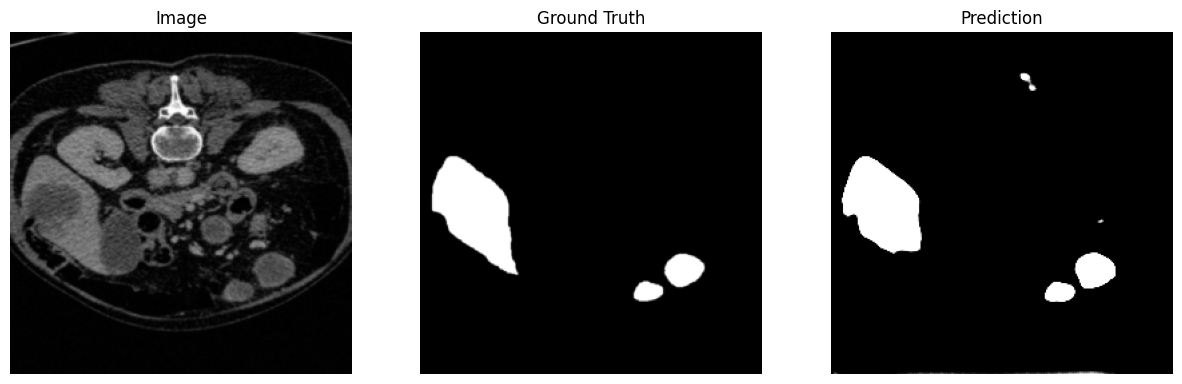

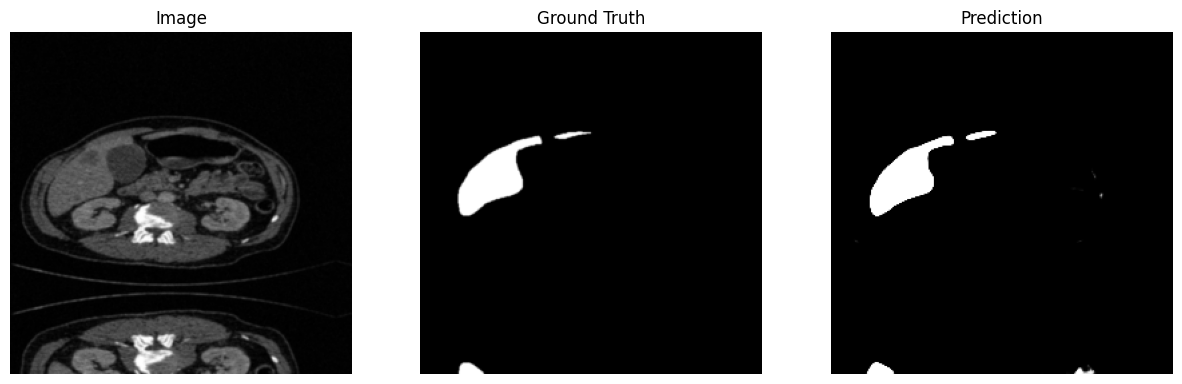

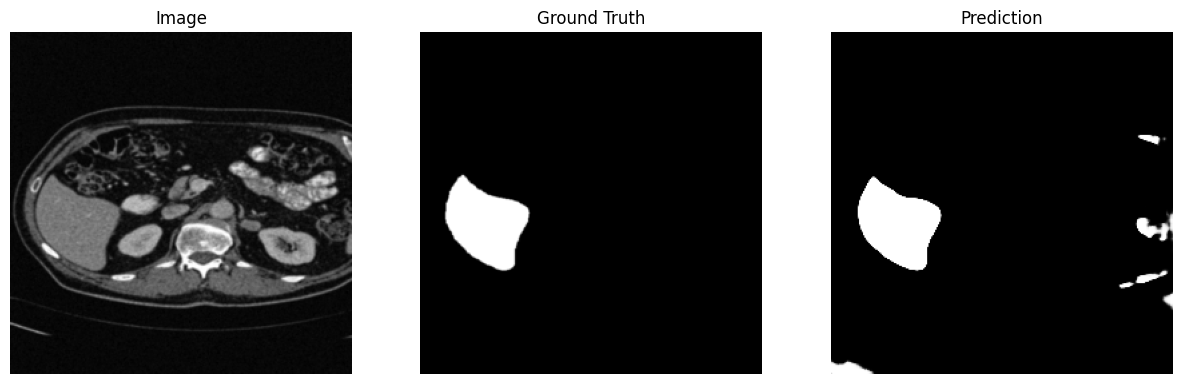

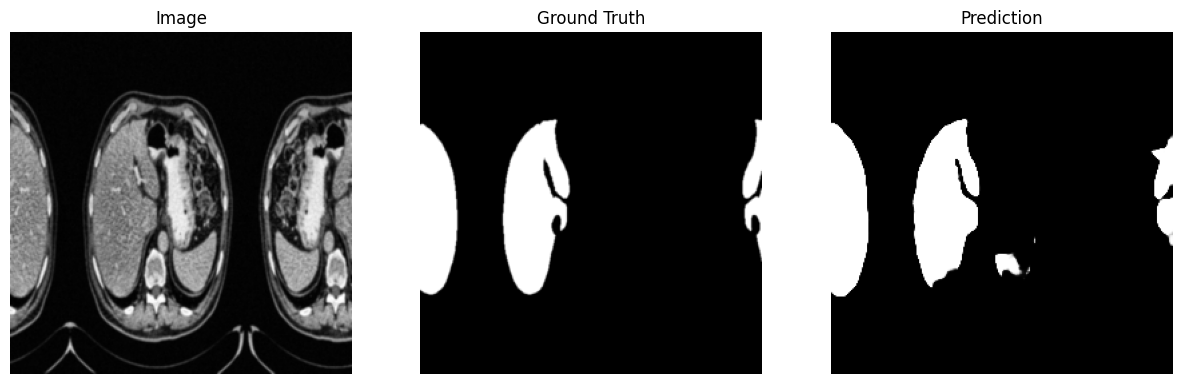

In [20]:


### Inference

import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'val_loader' is your DataLoader
batch = next(iter(val_loader))

with torch.no_grad():
    logits = postmodel(batch[0].to(device))  # Assuming image is at index 0
pr_masks = (torch.sigmoid(logits).squeeze(1)).float()  # Binary predictions

# Iterate through the batches
for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(15, 5))

    # Plot Image
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.title("Image")
    plt.axis("off")

    # Plot Ground Truth Mask
    plt.subplot(1, 3, 2)
    gt_mask_np = gt_mask.squeeze().cpu().numpy()
    plt.imshow(gt_mask_np, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    # Plot Prediction Mask
    plt.subplot(1, 3, 3)
    pr_mask_np = pr_mask.cpu().numpy()
    plt.imshow(pr_mask_np, cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [92]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image

# Vérifier si CUDA est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Définition du chemin de l'image
image_path = "/kaggle/input/digital-medical-images-for--download-resource/div-images/test/001.png"

if not os.path.exists(image_path):
    raise FileNotFoundError(f"❌ Le fichier {image_path} n'existe pas ! Vérifiez le chemin.")

#  Charger l'image en niveaux de gris
image_ct = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

if image_ct is None:
    raise ValueError(f"❌ Erreur de chargement de l'image {image_path}. Vérifiez que le fichier est valide.")

#  Appliquer la transformation "windowed"
def windowed(img: np.ndarray, w: int, l: int):
    px_min, px_max = l - w // 2, l + w // 2
    img = np.clip(img, px_min, px_max)
    return (img - px_min) / (px_max - px_min)

image_ct = windowed(image_ct, 400, 40)

#  Convertir en Image PIL pour appliquer les transformations PyTorch
image_pil = Image.fromarray((image_ct * 255).astype(np.uint8))

#  Définir la transformation avec Resize
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adapter à la taille d'entrée du modèle
    transforms.ToTensor(),  # Convertir en tenseur normalisé [0,1]
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalisation
])

#  Appliquer la transformation et ajouter une dimension batch (1, 1, 256, 256)
input_image = transform(image_pil).unsqueeze(0).to(device)

#  Vérifier que le modèle est défini et chargé sur le bon device
assert 'postmodel' in globals(), " Erreur : Le modèle 'postmodel' n'est pas défini."
postmodel = postmodel.to(device)
postmodel.eval()  # Mode évaluation

#  Passage de l'image dans le modèle
with torch.no_grad():
    output_mask = postmodel(input_image)  # (1, 1, 256, 256)

#  Appliquer la fonction sigmoïde pour obtenir des probabilités
output_mask = torch.sigmoid(output_mask)

#  Convertir en NumPy et appliquer un seuil binaire
output_mask = output_mask.squeeze(0).squeeze(0).cpu().numpy()  # (256, 256)
binary_mask = (output_mask > 0.5).astype(np.uint8)  # Seuil 0.5 pour segmentation

#  Redimensionner le masque à la taille originale de l'image CT
binary_mask = cv2.resize(binary_mask, (image_ct.shape[1], image_ct.shape[0]), interpolation=cv2.INTER_NEAREST) * 255

#  Sauvegarder le masque segmenté
cv2.imwrite("Liver_Mask.png", binary_mask)

print(" Masque enregistré sous 'Liver_Mask.png'")

#  Vérifier les valeurs du masque
print(f" Min: {binary_mask.min()}, Max: {binary_mask.max()}, Moyenne: {binary_mask.mean()}")


 Masque enregistré sous 'Liver_Mask.png'
 Min: 0, Max: 255, Moyenne: 10.272216796875


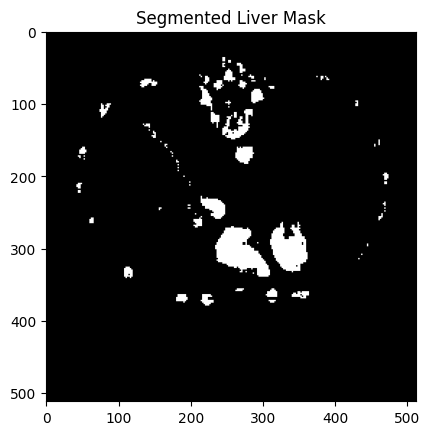

In [93]:
import matplotlib.pyplot as plt
import cv2

mask = cv2.imread("./Liver_Mask.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap="gray")
plt.title("Segmented Liver Mask")
plt.show()


In [94]:
print("Min pixel value:", mask.min())
print("Max pixel value:", mask.max())
print("Mean pixel value:", mask.mean())



Min pixel value: 0
Max pixel value: 255
Mean pixel value: 10.272216796875


In [91]:
print(output_mask.min(), output_mask.max(), output_mask.mean())


0.5 0.73105854 0.5056816


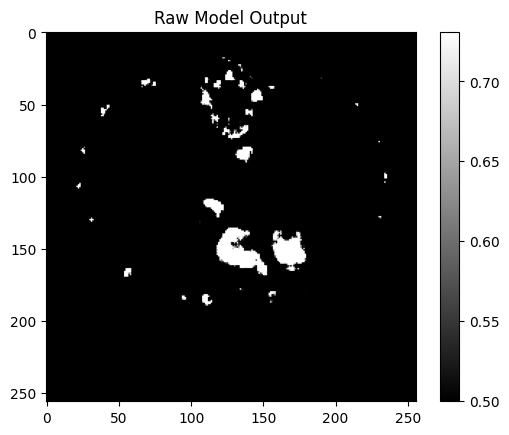

In [17]:
plt.imshow(output_mask, cmap="gray")
plt.colorbar()
plt.title("Raw Model Output")
plt.show()


In [18]:
def extract_intensity_features(image, mask):
    pixels = image[mask > 0]
    return {
        "mean_intensity": np.mean(pixels),
        "std_intensity": np.std(pixels),
        "min_intensity": np.min(pixels),
        "max_intensity": np.max(pixels)
    }

features_intensity = extract_intensity_features(image_ct, binary_mask)
print(features_intensity)


{'mean_intensity': 0.7581755, 'std_intensity': 0.08887632, 'min_intensity': 0.51, 'max_intensity': 1.0}


In [19]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops, label

def extract_texture_features(image, mask):
    """ Extrait des caractéristiques de texture à partir d'une image et d'un masque segmenté """
    labeled_mask = label(mask)  # Étiqueter les régions connectées
    properties = regionprops(labeled_mask, intensity_image=image)

    if not properties:
        raise ValueError(" Aucun objet détecté dans le masque !")

    roi = properties[0].intensity_image  # Zone segmentée

    # Calculer la matrice GLCM
    glcm = graycomatrix(roi.astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # Extraire les propriétés
    features = {
        "contrast": graycoprops(glcm, 'contrast')[0, 0],
        "homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "energy": graycoprops(glcm, 'energy')[0, 0],
        "correlation": graycoprops(glcm, 'correlation')[0, 0]
    }
    
    return features

# 🔹 Extraction des caractéristiques
features_texture = extract_texture_features(image_ct, binary_mask)
print(" Caractéristiques de texture extraites :", features_texture)


 Caractéristiques de texture extraites : {'contrast': 0.0, 'homogeneity': 1.0, 'energy': 1.0, 'correlation': 1.0}


In [20]:
def extract_shape_features(mask):
    labeled_mask = label(mask)
    properties = regionprops(labeled_mask)
    
    if len(properties) == 0:
        return None
    
    prop = properties[0]
    return {
        "area": prop.area,
        "perimeter": prop.perimeter,
        "circularity": (4 * np.pi * prop.area) / (prop.perimeter ** 2) if prop.perimeter > 0 else 0,
        "eccentricity": prop.eccentricity
    }

features_shape = extract_shape_features(binary_mask)
print(features_shape)


{'area': 24.0, 'perimeter': 16.0, 'circularity': 1.1780972450961724, 'eccentricity': 0.7559289460184544}


In [21]:
import pandas as pd

# Fusionner les caractéristiques
features = {**features_intensity, **features_texture, **features_shape}

# Enregistrer en CSV
df = pd.DataFrame([features])
df.to_csv("hepatic_biomarkers.csv", index=False)
print(" Biomarqueurs enregistrés !")


 Biomarqueurs enregistrés !


In [22]:
import pandas as pd

# 🔹 Convertir le dictionnaire en DataFrame
df_features = pd.DataFrame([features_texture])  # [features_texture] pour garder les colonnes

# 🔹 Sauvegarder dans un fichier CSV
csv_path = "Liver_Features.csv"
df_features.to_csv(csv_path, index=False)  # Enregistrer sans index

print(f" Caractéristiques enregistrées dans {csv_path}")
print(df_features)


 Caractéristiques enregistrées dans Liver_Features.csv
   contrast  homogeneity  energy  correlation
0       0.0          1.0     1.0          1.0


In [23]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import pandas as pd
import skimage.feature
print(dir(skimage.feature))

#from skimage.feature.texture import greycomatrix, greycoprops
#from skimage.feature import graycomatrix, graycoprops

from skimage.feature import graycomatrix, graycoprops


from PIL import Image

# Vérifier si CUDA est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définition des chemins
image_dir = "/kaggle/input/digital-medical-images-for--download-resource/div-images/test/"
output_csv = "Liver_Features.csv"

# Fonction de transformation d'image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Erreur : Impossible de charger {image_path}")

    image = image.astype(np.float32)

    # Appliquer la transformation "windowed"
    def windowed(tensor: np.ndarray, w: int, l: int):
        px_min = l - w // 2
        px_max = l + w // 2
        tensor = np.clip(tensor, px_min, px_max)
        return (tensor - px_min) / (px_max - px_min)

    image = windowed(image, 400, 40)
    image_pil = Image.fromarray((image * 255).astype(np.uint8))

    # Transformation PyTorch
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    return transform(image_pil).unsqueeze(0).to(device), image  # (image pré-traitée, image originale)

# Fonction de segmentation avec le modèle U-Net
def segment_liver(model, input_image):
    with torch.no_grad():
        output_mask = model(input_image)
    output_mask = torch.sigmoid(output_mask).squeeze(0).squeeze(0).cpu().numpy()
    return (output_mask > 0.5).astype(np.uint8) * 255  # Seuil 0.5

from skimage.measure import regionprops, label
from skimage.transform import resize

def extract_features(image, mask):
    #  Redimensionner le masque à la taille originale de l'image
    mask_resized = resize(mask, image.shape, order=0, preserve_range=True).astype(np.uint8)
    
    #  Labelliser les régions
    labeled_mask = label(mask_resized)
    
    #  Extraire les propriétés des régions segmentées
    properties = regionprops(labeled_mask, intensity_image=image)

    if len(properties) == 0:
        return None

    #  Extraire les caractéristiques de la première région (foie segmenté)
    props = properties[0]
    features = {
        "area": props.area,
        "mean_intensity": props.mean_intensity,
        "std_intensity": props.intensity_image.std(),
        "min_intensity": props.intensity_image.min(),
        "max_intensity": props.intensity_image.max(),
    }
    return features

# Charger le modèle
assert 'postmodel' in globals(), "Erreur : Le modèle 'postmodel' n'est pas défini."
postmodel = postmodel.to(device)
postmodel.eval()

# Traitement de plusieurs images
features_list = []
for filename in os.listdir(image_dir):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        image_path = os.path.join(image_dir, filename)

        input_image, original_image = preprocess_image(image_path)
        binary_mask = segment_liver(postmodel, input_image)

        features = extract_features(original_image, binary_mask)
        if features:
            features["patient_id"] = filename  # Ajouter ID du patient
            features_list.append(features)

# Convertir en DataFrame et sauvegarder
df_features = pd.DataFrame(features_list)
df_features.to_csv(output_csv, index=False)
print(f"✅ Caractéristiques enregistrées dans {output_csv}")
print(df_features.head())


['BRIEF', 'CENSURE', 'Cascade', 'ORB', 'SIFT', 'blob_dog', 'blob_doh', 'blob_log', 'canny', 'corner_fast', 'corner_foerstner', 'corner_harris', 'corner_kitchen_rosenfeld', 'corner_moravec', 'corner_orientations', 'corner_peaks', 'corner_shi_tomasi', 'corner_subpix', 'daisy', 'draw_haar_like_feature', 'draw_multiblock_lbp', 'fisher_vector', 'graycomatrix', 'graycoprops', 'haar_like_feature', 'haar_like_feature_coord', 'hessian_matrix', 'hessian_matrix_det', 'hessian_matrix_eigvals', 'hog', 'learn_gmm', 'local_binary_pattern', 'match_descriptors', 'match_template', 'multiblock_lbp', 'multiscale_basic_features', 'peak_local_max', 'plot_matched_features', 'shape_index', 'structure_tensor', 'structure_tensor_eigenvalues']
✅ Caractéristiques enregistrées dans Liver_Features.csv
      area  mean_intensity  std_intensity  min_intensity  max_intensity  \
0  15720.0        0.999504       0.483240            0.0            1.0   
1  14720.0        0.999307       0.482992            0.0           

In [24]:
import random
df_features["severity"] = [random.choice([0, 1, 2]) for _ in range(len(df_features))]
df_features.to_csv(output_csv, index=False)
print(df_features.head())


      area  mean_intensity  std_intensity  min_intensity  max_intensity  \
0  15720.0        0.999504       0.483240            0.0            1.0   
1  14720.0        0.999307       0.482992            0.0            1.0   
2    108.0        0.855347       0.432055            0.0            1.0   
3    168.0        0.850446       0.373698            0.0            1.0   
4   1072.0        0.871465       0.399307            0.0            1.0   

     patient_id  severity  
0  010_mask.png         2  
1  011_mask.png         1  
2       007.png         2  
3       005.png         2  
4       011.png         0  


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Charger les données
df = pd.read_csv(output_csv)

# Séparer les caractéristiques et la cible
X = df.drop(columns=["patient_id", "severity"])
y = df["severity"]

# Diviser les données en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Prédire sur les données de test
y_pred = clf.predict(X_test)

# Évaluer la performance
print(f" Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))


 Accuracy: 0.57
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.00      0.00      0.00         2
           2       0.50      1.00      0.67         2

    accuracy                           0.57         7
   macro avg       0.39      0.56      0.44         7
weighted avg       0.43      0.57      0.48         7



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


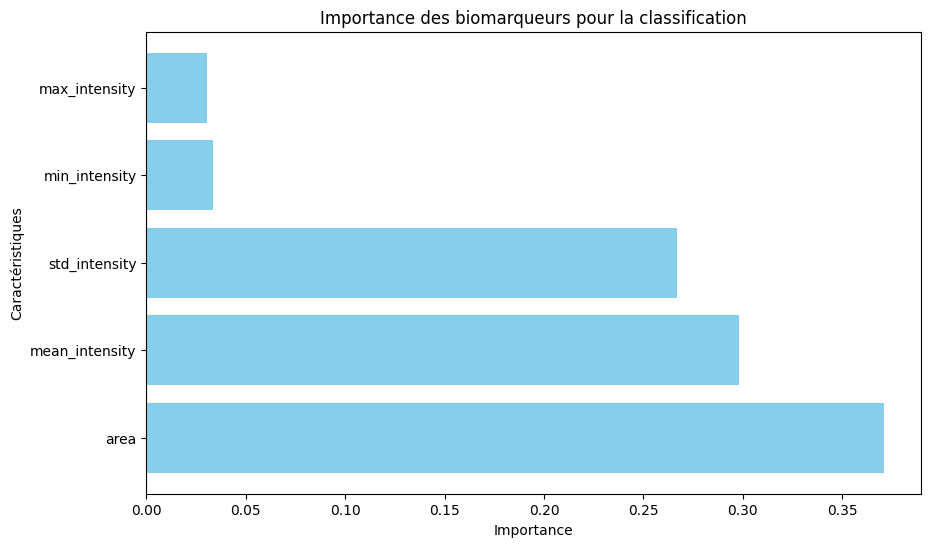

In [26]:
import matplotlib.pyplot as plt

# Extraire l'importance des caractéristiques
importances = clf.feature_importances_
feature_names = X.columns

# Affichage sous forme de barres
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Caractéristiques")
plt.title("Importance des biomarqueurs pour la classification")
plt.show()


In [27]:
import os
import cv2
import numpy as np
import torch
import pandas as pd
import torchvision.transforms as transforms
from PIL import Image
from skimage.measure import regionprops, label
from skimage.transform import resize

# Vérifier si CUDA est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dossier contenant les images
image_folder = "/kaggle/input/digital-medical-images-for--download-resource/div-images/test/"
output_csv = "liver_features.csv"

# Charger le modèle
assert 'postmodel' in globals(), "Erreur : Le modèle 'postmodel' n'est pas défini."
postmodel = postmodel.to(device)
postmodel.eval()  

# Fonction pour appliquer la transformation "windowed"
def windowed(tensor: np.ndarray, w: int, l: int):
    px_min = l - w // 2
    px_max = l + w // 2
    tensor = np.clip(tensor, px_min, px_max)
    return (tensor - px_min) / (px_max - px_min)

# Fonction de transformation pour PyTorch
transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

# Fonction de segmentation du foie
def segment_liver(model, image):
    input_image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output_mask = model(input_image)
    
    output_mask = torch.sigmoid(output_mask).squeeze(0).squeeze(0).cpu().numpy()
    binary_mask = (output_mask > 0.5).astype(np.uint8) * 255  # Seuil 0.5
    
    return binary_mask

# Fonction d'extraction des caractéristiques
def extract_features(image, mask):
    # Redimensionner le masque à la taille originale
    mask_resized = resize(mask, image.shape, order=0, preserve_range=True).astype(np.uint8)
    labeled_mask = label(mask_resized)

    properties = regionprops(labeled_mask, intensity_image=image)
    
    if len(properties) == 0:
        return None

    props = properties[0]
    features = {
        "area": props.area,
        "mean_intensity": props.mean_intensity,
        "std_intensity": props.intensity_image.std(),
        "min_intensity": props.intensity_image.min(),
        "max_intensity": props.intensity_image.max(),
    }
    return features

# Liste pour stocker toutes les caractéristiques
features_list = []

# Itérer sur toutes les images du dossier
for filename in os.listdir(image_folder):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        image_path = os.path.join(image_folder, filename)
        
        # Charger l'image en niveaux de gris
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue  # Passer l'image si erreur

        # Appliquer la transformation windowed
        image = windowed(image.astype(np.float32), 400, 40)
        image_pil = Image.fromarray((image * 255).astype(np.uint8))  

        # Segmenter le foie
        binary_mask = segment_liver(postmodel, image_pil)

        # Extraire les caractéristiques
        features = extract_features(image, binary_mask)
        if features:
            features["patient_id"] = filename  # Ajouter l'ID du patient
            features_list.append(features)

# Convertir la liste en DataFrame
df = pd.DataFrame(features_list)

# Sauvegarder en CSV
df.to_csv(output_csv, index=False)
print(f" Données enregistrées dans {output_csv}")


 Données enregistrées dans liver_features.csv


In [28]:
import pandas as pd

df = pd.read_csv("liver_features.csv")
print(df.head())


      area  mean_intensity  std_intensity  min_intensity  max_intensity  \
0  15720.0        0.999504       0.483240            0.0            1.0   
1  14720.0        0.999307       0.482992            0.0            1.0   
2    108.0        0.855347       0.432055            0.0            1.0   
3    168.0        0.850446       0.373698            0.0            1.0   
4   1072.0        0.871465       0.399307            0.0            1.0   

     patient_id  
0  010_mask.png  
1  011_mask.png  
2       007.png  
3       005.png  
4       011.png  


In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Charger les caractéristiques
df = pd.read_csv("liver_features.csv")

# Vérifier les premières lignes
print(df.head())

# Vérifier les valeurs manquantes
print(df.isnull().sum())

# Remplir les valeurs manquantes par la médiane
df.fillna(df.median(), inplace=True)


      area  mean_intensity  std_intensity  min_intensity  max_intensity  \
0  15720.0        0.999504       0.483240            0.0            1.0   
1  14720.0        0.999307       0.482992            0.0            1.0   
2    108.0        0.855347       0.432055            0.0            1.0   
3    168.0        0.850446       0.373698            0.0            1.0   
4   1072.0        0.871465       0.399307            0.0            1.0   

     patient_id  
0  010_mask.png  
1  011_mask.png  
2       007.png  
3       005.png  
4       011.png  
area              0
mean_intensity    0
std_intensity     0
min_intensity     0
max_intensity     0
patient_id        0
dtype: int64


TypeError: Cannot convert [['010_mask.png' '011_mask.png' '007.png' '005.png' '011.png' '013.png'
  '000_mask.png' '004.png' '002.png' '003_mask.png' '012_mask.png'
  '015_mask.png' '004_mask.png' '005_mask.png' '000.png' '003.png'
  '015.png' '001_mask.png' '006_mask.png' '008_mask.png' '001.png'
  '013_mask.png' '012.png' '009.png' '007_mask.png' '014_mask.png'
  '002_mask.png' '010.png' '008.png' '006.png' '014.png' '009_mask.png']] to numeric

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


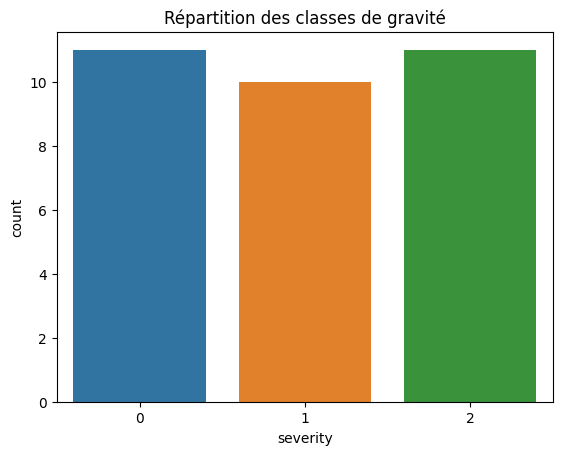

In [30]:
# Ajouter une colonne "gravité" (exemple : segmentation en 3 classes)
df["severity"] = pd.qcut(df["mean_intensity"], q=3, labels=[0, 1, 2])  # 0 = Léger, 1 = Modéré, 2 = Sévère

# Vérifier la distribution des classes
sns.countplot(x=df["severity"])
plt.title("Répartition des classes de gravité")
plt.show()


In [31]:
# Définir les caractéristiques (X) et la cible (y)
X = df.drop(columns=["patient_id", "severity"])  # Supprimer l'ID du patient
y = df["severity"]

# Diviser en train/test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normaliser les caractéristiques
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


 Accuracy : 1.00
📊 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



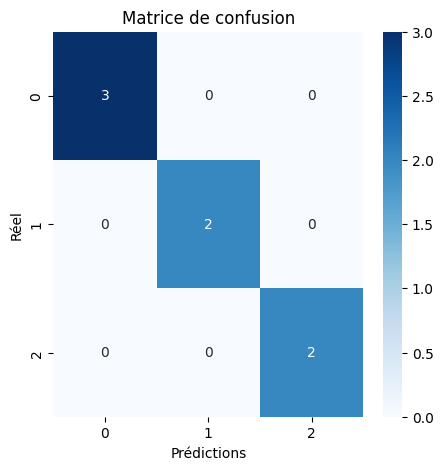

In [32]:
# Initialiser et entraîner le modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions sur le test set
y_pred = model.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
print(f" Accuracy : {accuracy:.2f}")

# Afficher le rapport de classification
print("📊 Rapport de classification :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()



📊 Top 5 Biomarqueurs les plus importants :
          Feature  Importance
1  mean_intensity    0.539745
2   std_intensity    0.225875
0            area    0.196372
3   min_intensity    0.028253
4   max_intensity    0.009755


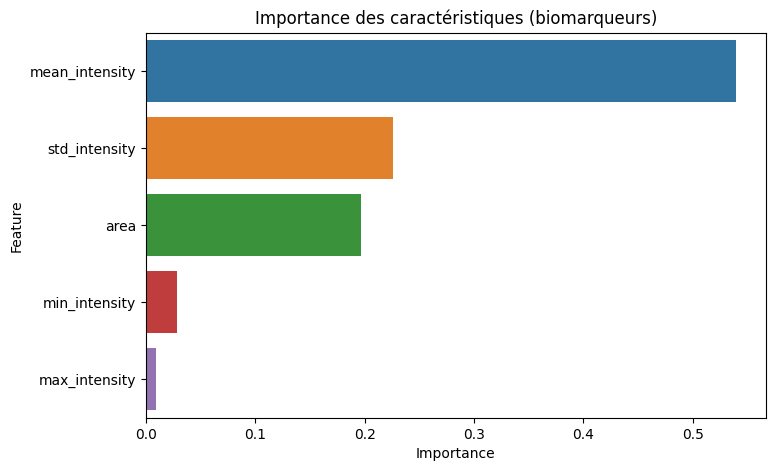

In [33]:
# Extraire l'importance des caractéristiques
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Afficher les 5 caractéristiques les plus importantes
print("📊 Top 5 Biomarqueurs les plus importants :")
print(feature_importance.head())

# Visualisation
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Importance des caractéristiques (biomarqueurs)")
plt.show()


In [34]:
# Exemple de caractéristiques d'un nouveau patient (à adapter avec tes vraies valeurs)
new_patient = np.array([[500, 120.5, 15.3, 60, 180]])  # (area, mean_intensity, std_intensity, min_intensity, max_intensity)

# Normalisation des données
new_patient = scaler.transform(new_patient)

# Prédiction
severity_prediction = model.predict(new_patient)
print(f"🩺 Gravité prédite : {severity_prediction[0]}")


🩺 Gravité prédite : 2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
